In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from torch import tensor, Tensor
from scipy.stats.sampling import DiscreteAliasUrn
import numpy as np
from sklearn.preprocessing import normalize
from utils.node2vec import Node2VecModel, train_node2vec
from torch.multiprocessing import cpu_count
from sklearn.manifold import TSNE

### Các Hyperparameter


In [2]:
EMBEDDING_SIZE = 64
WALK_LENGTH = 10
WALKS_PER_VERTEX = 10
WINDOW_SIZE = 3
START_LEARNING_RATE = 0.025
END_LEARNING_RATE = 0.000
# kích thước negative sample
K = 5
# return parameter
p = 2.0
# io parameter
q = 1.0
# Dùng cho TSNE
PERPLEXITY = 20

device và worker_threads


In [3]:
WORKER_THREADS = torch.cuda.device_count(
) if torch.cuda.is_available() else cpu_count()

# giảm overhead cho dataset nhỏ

WORKER_THREADS = 1

CHUNK_SIZE = 4


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print(WORKER_THREADS)

cpu
1


### Load dataset


[0.45958799 0.25851825 0.28724249 0.1723455  0.08617275 0.114897
 0.114897   0.114897   0.14362125 0.0574485  0.08617275 0.02872425
 0.0574485  0.14362125 0.0574485  0.0574485  0.0574485  0.0574485
 0.0574485  0.08617275 0.0574485  0.0574485  0.0574485  0.14362125
 0.08617275 0.08617275 0.0574485  0.114897   0.08617275 0.114897
 0.114897   0.1723455  0.34469099 0.48831224]


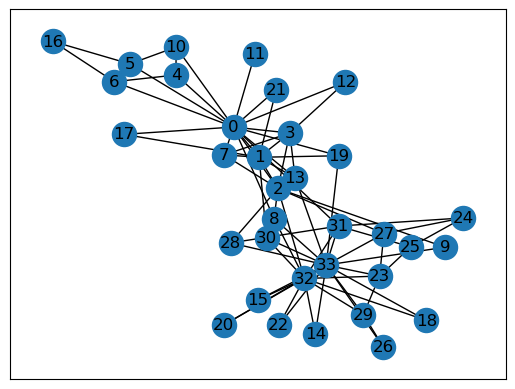

In [4]:
# Load dataset
g: nx.Graph = nx.karate_club_graph()
adj_lists = [list(g.neighbors(v)) for v in g]
vertices = list(g)
V = len(g)

# noise distribution cho negative sampling, được khởi tạo xấp xỉ bằng phân bố bậc của đỉnh
noise_distr = normalize([[deg for v, deg in g.degree]])[0]

nx.draw_networkx(g)
print(noise_distr)

In [5]:
# Xây dựng Transition RNG:(|V| * deg^2)
# ánh xạ từ (đỉnh hiện tại v, đỉnh trước đó t) -> rng để sinh ra index cho đỉnh tiếp theo x
transition_rng: list[dict[int, DiscreteAliasUrn]] = []

for v in g:
    back_vertex_to_rng: dict[int, DiscreteAliasUrn] = {}

    # với đỉnh đầu tiên trong 1 walk thì mọi alpha bằng 1
    for t in adj_lists[v] + [v]:
        pi = np.ones((len(adj_lists[v]),))
        for i, x in enumerate(adj_lists[v]):
            if t == x:
                # x là t (xác suất quay lại)
                pi[i] = 1.0 / p
            elif g[x].get(t, None) is None:
                # nếu không có cạnh giữa x và t
                pi[i] = 1.0 / q
                # alpha = 1 nếu nếu giữa x và t có cạnh
            # nhân xác xuất với trọng số cạnh
            pi[i] *= g[v][x]["weight"]
        # chuẩn hóa phân bố xác xuất
        probs = normalize([pi])[0]
        # tạo rng để sinh ra idx cho x khi đang ở v và vừa đi ra từ v
        back_vertex_to_rng[t] = DiscreteAliasUrn(
            probs, random_state=np.random.default_rng()
        )

    transition_rng.append(back_vertex_to_rng)

In [6]:
model = Node2VecModel(V=V, emb_sz=EMBEDDING_SIZE, k=K).to(device)
loss_records = []

if WORKER_THREADS > 1:
    model.share_memory()
train_node2vec(
    model=model,
    start_lr=START_LEARNING_RATE,
    end_lr=END_LEARNING_RATE,
    vertices=vertices,
    adj_lists=adj_lists,
    loss_records=loss_records,
    walk_len=WALK_LENGTH,
    walks_per_vertex=WALKS_PER_VERTEX,
    window_sz=WINDOW_SIZE,
    worker_threads=WORKER_THREADS,
    chunk_sz=CHUNK_SIZE,
    noise_distr=noise_distr,
    transition_rng=transition_rng,
)

  0%|          | 0/10 [00:00<?, ?it/s]

'Final noise distribution:'

array([0.35259519, 0.24212773, 0.27034835, 0.19016212, 0.10054646,
       0.16945049, 0.15877548, 0.14822369, 0.19656307, 0.04791467,
       0.10676733, 0.05727652, 0.08460859, 0.16307336, 0.08058255,
       0.10387973, 0.08593638, 0.05214448, 0.05575359, 0.06225943,
       0.05109808, 0.05828434, 0.10096512, 0.21014605, 0.0890084 ,
       0.17050553, 0.08013111, 0.14378412, 0.07922567, 0.14489825,
       0.12553764, 0.2150422 , 0.32916865, 0.41950018])

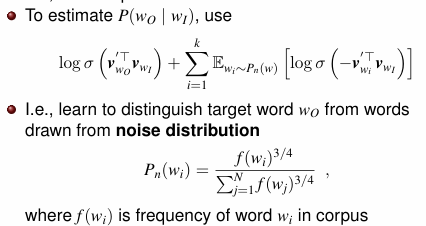


Text(0.5, 1.0, 'Hàm mất mát theo thời gian')

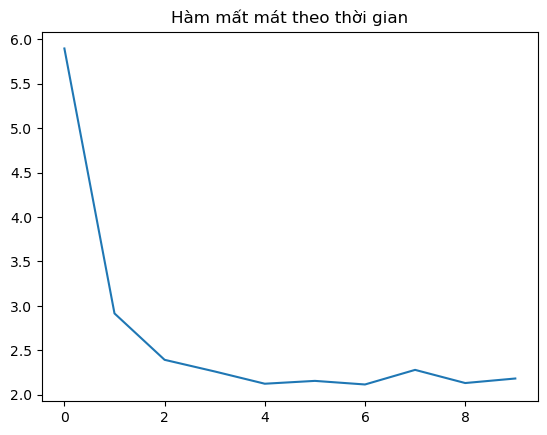

In [7]:
plt.tick_params("y")
plt.plot(loss_records)
plt.title("Hàm mất mát theo thời gian")

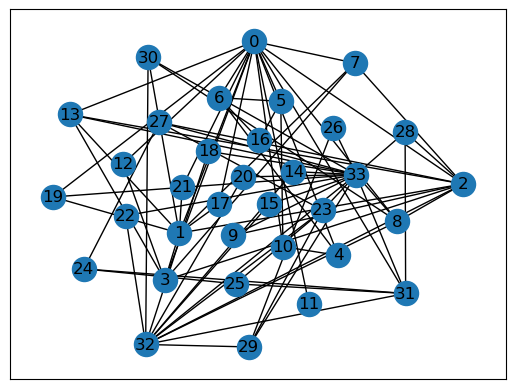

In [8]:
emb = model.embedding_layer(tensor(list(g))).detach().cpu().numpy()
emb_2d = TSNE(n_components=2, perplexity=PERPLEXITY).fit_transform(emb)
pos = {v: v_emb for v, v_emb in enumerate(emb_2d)}

nx.draw_networkx(g, pos)

In [9]:
df = pd.DataFrame(emb)
df.to_csv("out/karate_node2vec_emb.csv", header=False, index=False)
df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.004670,1.749606,-0.835006,1.255301,0.936006,0.299373,-0.681133,0.476577,1.946334,1.077392,...,0.440196,-1.542094,0.076780,-0.770785,0.981289,0.750643,0.459125,0.869605,-0.125492,0.001896
1,-1.520321,0.362257,-0.493418,0.747596,1.094832,-0.744986,0.890197,-1.142565,0.755803,1.438343,...,-0.447065,-1.965080,0.653454,-0.156760,0.361599,-0.729476,-1.375919,1.079643,-0.528519,0.187572
2,0.100710,-1.570123,-0.180806,0.281211,-1.065753,0.653802,-1.077558,-1.592751,0.057117,-0.655012,...,0.278936,-1.817439,1.681118,0.309727,-0.689361,-0.154218,0.822169,0.282760,-1.932804,-1.849765
3,-1.366379,0.056548,0.376864,-2.150578,-0.731027,0.503595,-1.083570,0.751851,-2.480133,0.985858,...,0.387282,0.775270,0.005018,-0.250165,-0.934801,-0.111060,0.661227,-0.328198,0.328398,-0.265605
4,1.095248,-1.151299,-1.047686,-1.131332,0.795722,-0.613506,0.116581,-0.513539,-1.174834,-0.833029,...,0.521510,-1.097361,-0.619558,-0.638294,0.714367,-0.398543,-1.111844,-0.514016,0.007825,-1.868668
5,-0.152220,1.186942,0.475736,1.117643,1.009954,-0.733481,0.525401,-0.948583,-0.969529,0.390611,...,-0.284053,0.903140,-0.873748,-1.742077,0.739091,0.009372,0.590055,-0.094573,-1.207267,0.542393
6,-0.651245,-0.387689,0.887077,0.829008,0.466386,1.195651,-0.303617,1.333929,0.449382,-1.690388,...,-1.117418,-1.493515,1.064806,1.665506,-1.180771,0.559746,-1.384735,-0.020566,1.797084,1.365226
7,0.370483,-0.646913,-0.561915,0.632980,1.889706,1.383121,-0.815536,1.404248,1.417211,-1.270392,...,-0.938522,1.348760,-1.336168,1.859721,-0.305951,-1.851893,0.182774,-1.394039,-1.308254,1.609360
8,0.205706,-0.437150,1.515321,0.202540,-2.306734,1.621739,-0.293846,1.282951,-0.089652,-0.477733,...,-1.834058,-1.052466,-1.050014,0.289413,0.639068,-0.894968,-1.248291,0.278399,-0.397385,-0.211553
9,-0.933409,0.522978,-0.462044,0.283275,-0.314487,0.682111,1.046965,-1.457144,-0.542317,-0.346419,...,-2.180410,-0.564505,-1.097247,-0.210057,0.877275,0.473531,0.171342,-0.712215,1.213562,-0.152461
